In [106]:
#Import Libraries
import pandas as pd
import numpy as np
from numpy import mean
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
import shap
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
#rcParams['figure.figsize']=16,15
rcParams.update({'font.size': 14})
# pd.options.display.max_columns = 25
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from category_encoders.cat_boost import CatBoostEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, average_precision_score

In [ ]:
# CONFIG
RANDOM_STATE = 42
TEST_SIZE = 0.30

DROP_COLS = [
    "Visit_Year", "Patient_ID", "PRIOR_PROVIDER_TYPE", "TOTAL", "AllocProportion",
    "SampleSize", "ActualProportion", "SelectionProb", "SamplingWeight",
]

MONTH_MAP = {
            "Jan":1, "Feb":2, "Mar":3, "Apr":4,
            "May":5, "Jun":6, "Jul":7, "Aug":8,
            "Sep":9, "Oct":10, "Nov":11,"Dec":12
        }
        

CYCLICAL_COLS = ["Visit_Date", "Visit_Month"]

BINARY_COLS = ["Local_Resident"]

TARGET_COL = "Admitted"

In [108]:
df = pd.read_csv("hospital_admissions_with_missing.csv")
print(f"Data shape: {df.shape}")
df.head()

Data shape: (5000, 35)


,Admitted,avg_income,CLINIC_VISIT,REFERRAL_SOURCE,Visit_Date,Visit_Month,Visit_Year,distance_to_hospital,ETHNICITY,BMI,Patient_ID,symptom_duration,Local_Resident,BP_Score,Pulse_Score,interest_in_admission,PRIOR_PROVIDER_TYPE,INSURANCE_TYPE,FOLLOWUP_EMAILS,REFERRED_BY_SPECIALIST,REFERRAL_CONTACTS,OXYGEN_LEVEL,PATIENT_CALLS,sex,HOSPITAL_REACHOUTS,TELEMEDICINE_SCORE,SERVICE_REGION,TOTAL_CONTACTS,TRAVEL_REQUESTS,TOTAL,AllocProportion,SampleSize,ActualProportion,SelectionProb,SamplingWeight
0,0,46045.39,0,ER,4,Jan,2024,11.40,Asian,35.2,10001,9,Y,120.417310,82.2,3,Private,Medicaid,2,1,0,96.534471,0,1,2,3.1,North,11,1,0,0.79,528,0.20,0.1396,1.83
1,0,19145.43,1,Self,4,Sep,2025,5.20,White,26.3,10002,6,Y,114.322884,81.0,2,Private,Medicaid,2,1,3,98.117134,5,0,3,2.7,East,13,2,4,0.67,904,0.24,0.1276,1.87
2,0,48816.69,0,Self,9,Oct,2023,2.67,NaN,25.2,10003,8,Y,116.918848,62.7,2,NaN,Uninsured,0,1,3,96.106006,0,1,4,4.3,North,7,2,4,0.69,607,0.17,0.1422,1.37
3,0,68702.11,0,ER,8,Mar,2024,13.27,White,26.9,10004,5,Y,131.209240,75.5,5,Govt,Private,3,1,3,96.977680,3,0,4,2.4,South,9,0,0,0.70,878,0.12,0.0390,0.77
4,1,63064.45,0,Self,2,Sep,2024,14.49,Black,37.9,10005,13,N,110.722173,80.5,6,Private,Uninsured,2,1,1,95.202774,5,1,1,2.9,North,0,2,0,0.76,143,0.15,0.0824,0.71


# 2. Data Preprocessing

## a. Drop unnecessary variables.

In [109]:
# drop unneeded columns
print(f"Dropping columns: {DROP_COLS}")
subset_df = df.drop(columns=DROP_COLS)
print(f"Subset data shape: {subset_df.shape}")
subset_df.head()

Dropping columns: ['Visit_Year', 'Patient_ID', 'PRIOR_PROVIDER_TYPE', 'TOTAL', 'AllocProportion', 'SampleSize', 'ActualProportion', 'SelectionProb', 'SamplingWeight']
Subset data shape: (5000, 26)


,Admitted,avg_income,CLINIC_VISIT,REFERRAL_SOURCE,Visit_Date,Visit_Month,distance_to_hospital,ETHNICITY,BMI,symptom_duration,Local_Resident,BP_Score,Pulse_Score,interest_in_admission,INSURANCE_TYPE,FOLLOWUP_EMAILS,REFERRED_BY_SPECIALIST,REFERRAL_CONTACTS,OXYGEN_LEVEL,PATIENT_CALLS,sex,HOSPITAL_REACHOUTS,TELEMEDICINE_SCORE,SERVICE_REGION,TOTAL_CONTACTS,TRAVEL_REQUESTS
0,0,46045.39,0,ER,4,Jan,11.40,Asian,35.2,9,Y,120.417310,82.2,3,Medicaid,2,1,0,96.534471,0,1,2,3.1,North,11,1
1,0,19145.43,1,Self,4,Sep,5.20,White,26.3,6,Y,114.322884,81.0,2,Medicaid,2,1,3,98.117134,5,0,3,2.7,East,13,2
2,0,48816.69,0,Self,9,Oct,2.67,NaN,25.2,8,Y,116.918848,62.7,2,Uninsured,0,1,3,96.106006,0,1,4,4.3,North,7,2
3,0,68702.11,0,ER,8,Mar,13.27,White,26.9,5,Y,131.209240,75.5,5,Private,3,1,3,96.977680,3,0,4,2.4,South,9,0
4,1,63064.45,0,Self,2,Sep,14.49,Black,37.9,13,N,110.722173,80.5,6,Uninsured,2,1,1,95.202774,5,1,1,2.9,North,0,2


## b. Encode Cyclical Features – Visit_Date and Visit _Month.
## c.	Encode Local_Resident column to integer Values.
I started by mapping Visit_Month to numeric values. Then created a function to encode cyclical (Visit_Date,Visit_Month) features using sin/cos encoding (creating two columns _sin, _cos for each cyclical feature) and binary features (Local_resident) using the LabelEncoder (yes=1, no=2).

In [110]:
# map Visit_Month to numeric (i.e Jan=1, Feb=2, etc.)
subset_df['Visit_Month'] = subset_df['Visit_Month'].map(MONTH_MAP)
subset_df['Visit_Month'] = pd.to_numeric(subset_df['Visit_Month'], errors="coerce")
print("Sanity Check Nulls in Visit Month: " + str(subset_df['Visit_Month'].isnull().sum()))

Sanity Check Nulls in Visit Month: 0


In [111]:
# function to encode cyclical and binary features
def preprocess(dataframe, cyclical_features=None, binary_features=None):
    df = dataframe.copy()
    
    # encode cyclical features
    if cyclical_features:
        for feature in cyclical_features:
            df[feature + '_sin'] = np.sin(2 * np.pi * df[feature] / df[feature].max())
            df[feature + '_cos'] = np.cos(2 * np.pi * df[feature] / df[feature].max())
            df.drop(columns=[feature], inplace=True)

    # encode binary features
    if binary_features:
        le = LabelEncoder()
        for feature in binary_features:
            df[feature+'_encoded'] = le.fit_transform(df[feature])
            print("Classes:", le.classes_)
            print("Encoded values:", df[[feature, feature+'_encoded']].head(10))
            df.drop(columns=[feature], inplace=True)
    
            
    return df

In [112]:
# encode cyclical and binary features
model_df = preprocess(subset_df, cyclical_features=CYCLICAL_COLS, binary_features=BINARY_COLS)
model_df.head()

Classes: ['N' 'Y']
Encoded values:   Local_Resident  Local_Resident_encoded
0              Y                       1
1              Y                       1
2              Y                       1
3              Y                       1
4              N                       0
5              N                       0
6              N                       0
7              N                       0
8              N                       0
9              Y                       1


,Admitted,avg_income,CLINIC_VISIT,REFERRAL_SOURCE,distance_to_hospital,ETHNICITY,BMI,symptom_duration,BP_Score,Pulse_Score,interest_in_admission,INSURANCE_TYPE,FOLLOWUP_EMAILS,REFERRED_BY_SPECIALIST,REFERRAL_CONTACTS,OXYGEN_LEVEL,PATIENT_CALLS,sex,HOSPITAL_REACHOUTS,TELEMEDICINE_SCORE,SERVICE_REGION,TOTAL_CONTACTS,TRAVEL_REQUESTS,Visit_Date_sin,Visit_Date_cos,Visit_Month_sin,Visit_Month_cos,Local_Resident_encoded
0,0,46045.39,0,ER,11.40,Asian,35.2,9,120.417310,82.2,3,Medicaid,2,1,0,96.534471,0,1,2,3.1,North,11,1,0.724793,0.688967,0.500000,8.660254e-01,1
1,0,19145.43,1,Self,5.20,White,26.3,6,114.322884,81.0,2,Medicaid,2,1,3,98.117134,5,0,3,2.7,East,13,2,0.724793,0.688967,-1.000000,-1.836970e-16,1
2,0,48816.69,0,Self,2.67,NaN,25.2,8,116.918848,62.7,2,Uninsured,0,1,3,96.106006,0,1,4,4.3,North,7,2,0.968077,-0.250653,-0.866025,5.000000e-01,1
3,0,68702.11,0,ER,13.27,White,26.9,5,131.209240,75.5,5,Private,3,1,3,96.977680,3,0,4,2.4,South,9,0,0.998717,-0.050649,1.000000,6.123234e-17,1
4,1,63064.45,0,Self,14.49,Black,37.9,13,110.722173,80.5,6,Uninsured,2,1,1,95.202774,5,1,1,2.9,North,0,2,0.394356,0.918958,-1.000000,-1.836970e-16,0


## d. Extra Credit: Handle the missing values in the dataset
Started by examining columns with null values. Used median imputation for numerical columns & mode for categorical columns to preserve central tendency of the dataset.

In [113]:
# summary of missing values
missing_summary = pd.DataFrame({
    'num_missing': model_df.isnull().sum(),
    'pct_missing': model_df.isnull().mean() * 100
})
missing_summary = missing_summary[missing_summary['num_missing'] > 0]
missing_summary = missing_summary.sort_values(by='pct_missing', ascending=False)
print("Columns with missing values:")
print(missing_summary)

Columns with missing values:
                 num_missing  pct_missing
avg_income                75          1.5
OXYGEN_LEVEL              75          1.5
BMI                       75          1.5
ETHNICITY                 60          1.2
REFERRAL_SOURCE           60          1.2


In [114]:
# handle missing values
# for numerical columns, we will use median imputation
num_cols = model_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_cols.remove(TARGET_COL)
for col in num_cols:
    median_value = model_df[col].median()
    model_df[col].fillna(median_value, inplace=True)
# for categorical columns, we will use mode imputation
cat_cols = model_df.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
    mode_value = model_df[col].mode()[0]
    model_df[col].fillna(mode_value, inplace=True)
print("Missing values after imputation:")
print(model_df.isnull().sum().sum())  

Missing values after imputation:
0


# 3. Use 70-30 split for training and validation.	

In [115]:
# split data into train and test sets
X = model_df.drop(columns=[TARGET_COL])
y = model_df[TARGET_COL]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# check target distribution in train and test sets
print(y_test.value_counts(normalize=True))
print(y_train.value_counts(normalize=True))


Train shape: (3500, 27), Test shape: (1500, 27)
Admitted
0    0.813333
1    0.186667
Name: proportion, dtype: float64
Admitted
0    0.813429
1    0.186571
Name: proportion, dtype: float64


# 4. Build a Random Forest model to Predict Target (Admitted).                               

## a. Encode categorical variables using CatBoost encoding.

In [116]:
# encode categorical features using CatBoostEncoder
# encoding after train-test split to avoid data leakage
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns to encode: {cat_cols}")
cbe = CatBoostEncoder(cols=cat_cols, random_state=RANDOM_STATE)
X_train_enc = cbe.fit_transform(X_train, y_train)
X_test_enc = cbe.transform(X_test)
X_train_enc.head()

Categorical columns to encode: ['REFERRAL_SOURCE', 'ETHNICITY', 'INSURANCE_TYPE', 'SERVICE_REGION']


,avg_income,CLINIC_VISIT,REFERRAL_SOURCE,distance_to_hospital,ETHNICITY,BMI,symptom_duration,BP_Score,Pulse_Score,interest_in_admission,INSURANCE_TYPE,FOLLOWUP_EMAILS,REFERRED_BY_SPECIALIST,REFERRAL_CONTACTS,OXYGEN_LEVEL,PATIENT_CALLS,sex,HOSPITAL_REACHOUTS,TELEMEDICINE_SCORE,SERVICE_REGION,TOTAL_CONTACTS,TRAVEL_REQUESTS,Visit_Date_sin,Visit_Date_cos,Visit_Month_sin,Visit_Month_cos,Local_Resident_encoded
3769,35002.78,1,0.186571,9.44,0.186571,29.0,10,138.527787,79.2,5,0.186571,4,0,1,94.135399,3,1,4,2.5,0.186571,10,2,0.394356,0.918958,1.224647e-16,-1.000000,0
3529,50410.68,1,0.593286,7.36,0.186571,35.0,7,120.706710,73.2,3,0.186571,2,1,1,99.356017,5,1,0,3.1,0.186571,14,2,0.724793,0.688967,5.000000e-01,0.866025,0
496,49891.02,1,0.186571,16.23,0.186571,30.2,2,107.921126,66.9,4,0.093286,2,0,0,101.384283,1,1,1,2.8,0.186571,13,1,0.988468,0.151428,5.000000e-01,0.866025,1
3043,46674.75,0,0.395524,10.54,0.593286,31.0,5,119.816659,68.2,3,0.186571,0,1,0,99.342908,3,1,2,3.3,0.593286,10,0,0.101168,-0.994869,-5.000000e-01,-0.866025,0
3547,67128.57,1,0.186571,11.74,0.093286,30.2,1,116.773465,70.2,1,0.593286,3,0,2,100.867438,2,1,4,2.7,0.186571,7,0,0.485302,-0.874347,-8.660254e-01,-0.500000,1


## b. Choose the best hyperparameters using Grid or Random Search.

In [117]:
# use grid search to find best hyperparameters for RandomForestClassifier
param_grid = {
    'n_estimators': [50, 100, 300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
RF=RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced') #You can exclude class_weight parameter and use it only if it's a rare class classification problem
cross_validation = StratifiedKFold(n_splits=3,shuffle=True,random_state=1)
grid_search = GridSearchCV(estimator = RF, param_grid = param_grid, scoring='roc_auc', cv=cross_validation, n_jobs=-1,verbose = 2)
grid_search.fit(X_train_enc, y_train)
print(f"Best parameters: {grid_search.best_params_}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


## c. Report results (ROC Plot) from this model, explain the hyperparameters used in the model.
* See ROC plot below this code block: 
* ROC AUC: 0.9956
* Sensitivity: 0.8821
* Specificity: 0.9885

Evaluation:
* The AUC is extremely high indicating the model is distinguishing admitted vs. non-admitted well. Sensitivity is a bit lower than specificity, meaning the RF is slightly more likely to miss an admitted patient than to misclassify a non-admitted one.

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
* These parameters mean the best model built 100 fully grown trees (n_estimators), there was no depth restriction so trees could grow as deep as they needed to (max_depth) splitting until the leaves were pure (min_samples_leaf, min_samples_split) if possible.

ROC AUC: 0.9956
Sensitivity: 0.8821
Specificity: 0.9885


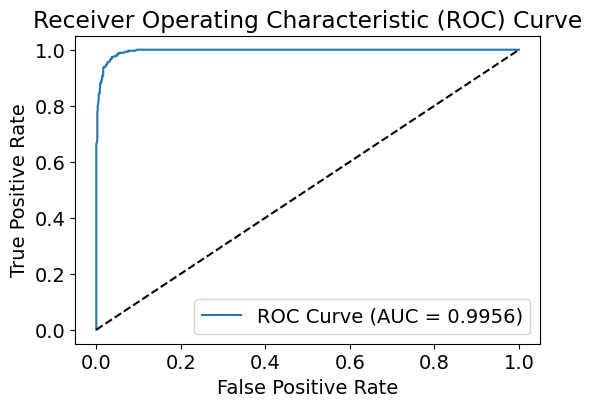

In [118]:
# Get the best model from grid search and evaluate on test set
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test_enc)
y_proba = best_rf.predict_proba(X_test_enc)[:, 1]
# roc-auc, sensitivity and specificity
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC: {roc_auc:.4f}")
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# 5. Build a LightGBM Classifier to Predict Target (Admitted).                                

## a. Encode categorical variables using CatBoost encoding or in-built LightGBM categorical feature conversion.
Using same CatBoost encoded dataset from the random forest model.

## b. Choose the best hyperparameters using Grid or Random Search.

In [119]:
# use grid search to find best hyperparameters for LightGBM
param_grid = {
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 500]
}
LGBM = lgb.LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced', verbose=-1)
cross_validation = StratifiedKFold(n_splits=3,shuffle=True,random_state=1)
grid_search = GridSearchCV(estimator = LGBM, param_grid = param_grid, scoring='roc_auc', cv=cross_validation, n_jobs=-1,verbose = 2)
grid_search.fit(X_train_enc, y_train)
print(f"Best parameters: {grid_search.best_params_}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500, 'num_leaves': 31}


## c. Report results (ROC Plot) from this model, explain the hyperparameters used in the model and how well does this model work compared to #4.
* See ROC plot below this code block: 
* ROC AUC: 0.9951
* Sensitivity: 0.9321
* Specificity: 0.9762

Evaluation
* LightGBM achieves an ROC AUC nearly identical to Random Forest. Compared to RF, it improves sensitivity (catches more admitted patients) while giving up a little specificity (slightly more false alarms). This makes LightGBM a more balanced model when the goal is to avoid missing true admissions, even if it means allowing a few more unnecessary admissions.

Best parameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500, 'num_leaves': 31}
* The max number of leaves for a meta classifier is 31 (num_leaves) with a depth of 10 (max_depth) saying each tree can go down 10 levels. Each boosting step contributes 10% of the correction (learning_rate) boosting with 100 iterations (n_estimators). The combination means LightGBM finds strong patterns without overfitting on small sample quirks. Compared to RF, the parameters emphasize efficient gradient boosting that focuses on correcting residual errors.

ROC AUC: 0.9951
Sensitivity: 0.9321
Specificity: 0.9762


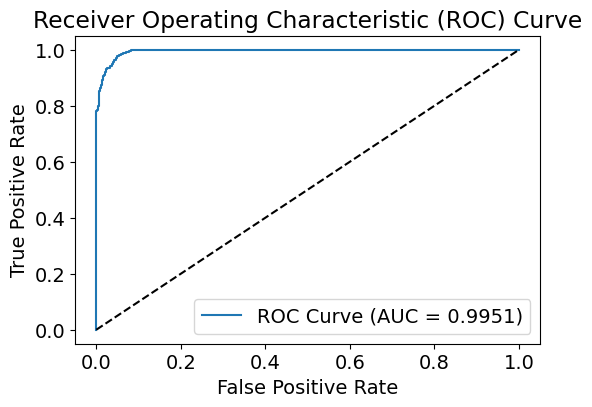

In [120]:
# get best model from grid search and evaluate on test set
best_lgb = grid_search.best_estimator_
y_pred = best_lgb.predict(X_test_enc)
y_proba = best_lgb.predict_proba(X_test_enc)[:, 1]
# roc-auc, sensitivity and specificity
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC: {roc_auc:.4f}")
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# 6.	Build XGBoost Classifier to Predict Target (Admitted).                                     

## a. Encode categorical variables using CatBoost encoding or in-built XGBoost categorical feature conversion.
Using same CatBoost encoded dataset from Random Forest Model

## b. Choose the best hyperparameters using Grid or Random Search.

In [121]:
# use grid search to find best hyperparameters for xgboost
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}
XGB = xgb.XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='auc', scale_pos_weight=(y==0).sum()/(y==1).sum())
cross_validation = StratifiedKFold(n_splits=3,shuffle=True,random_state=1)
grid_search = GridSearchCV(estimator = XGB, param_grid = param_grid, scoring='roc_auc', cv=cross_validation, n_jobs=-1,verbose = 2)
grid_search.fit(X_train_enc, y_train)
print(f"Best parameters: {grid_search.best_params_}")

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}


## c. Report results (ROC Plot) from this model, explain the hyperparameters used in the model and explain how well this model works compared to #4 and #5.
* See ROC plot below this code block:
* ROC AUC: 0.9951
* Sensitivity: 1.0000
* Specificity: 0.9172

Evaluation:
* XGBoost maintains a strong AUC while achieving perfect sensitivity. However, specificity drops sharply compared to RF and LightGBM, leading to a higher rate of false positives. This makes XGBoost the best option if the hospital’s top priority is not missing any admission, but less suitable if resources are constrained and false admissions are costly.

Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
* These parameters configure XGBoost as a highly regularized, conservative model: shallow trees (max_depth=3), small learning steps (learning_rate=0.01), and randomness at both the row (subsample) and feature (colsample_bytree) levels. This setup favors generalization and stability over aggressive fitting, which explains why the model achieved perfect sensitivity (capturing all true admissions) but allowed more false positives, lowering specificity.

ROC AUC: 0.9951
Sensitivity: 1.0000
Specificity: 0.9172


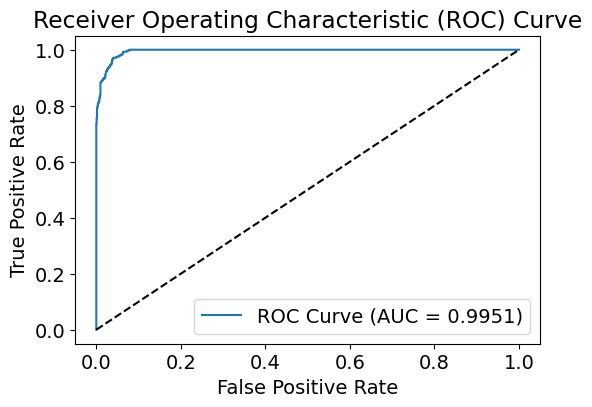

In [122]:
# get the best model from grid search and evaluate on test set
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test_enc)
y_proba = best_xgb.predict_proba(X_test_enc)[:, 1]
# ROC AUC, sensitivity and specificity
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC: {roc_auc:.4f}")
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## d. Run the SHAP summary plot for the model and explain the visual.
See plot below next code block:

Key variables: symptom_duration, interest_in_admission, OXYGEN_LEVEL, BP_Score

Directionality: The directions of impact the key variables have on the model makes logical sense: longer symptom duration has a positive impact on the outcome, higher interest in admission has positive impact, lower oxygen levels have positive impact, and higher bp_scores have a higher impact.

The model is most influenced by clinical severity measures (symptom duration, oxygen level, blood pressure) and patient intent (interest in admission). Demographic and logistical features (distance, service region, ethnicity) virtually no impact on the model. 

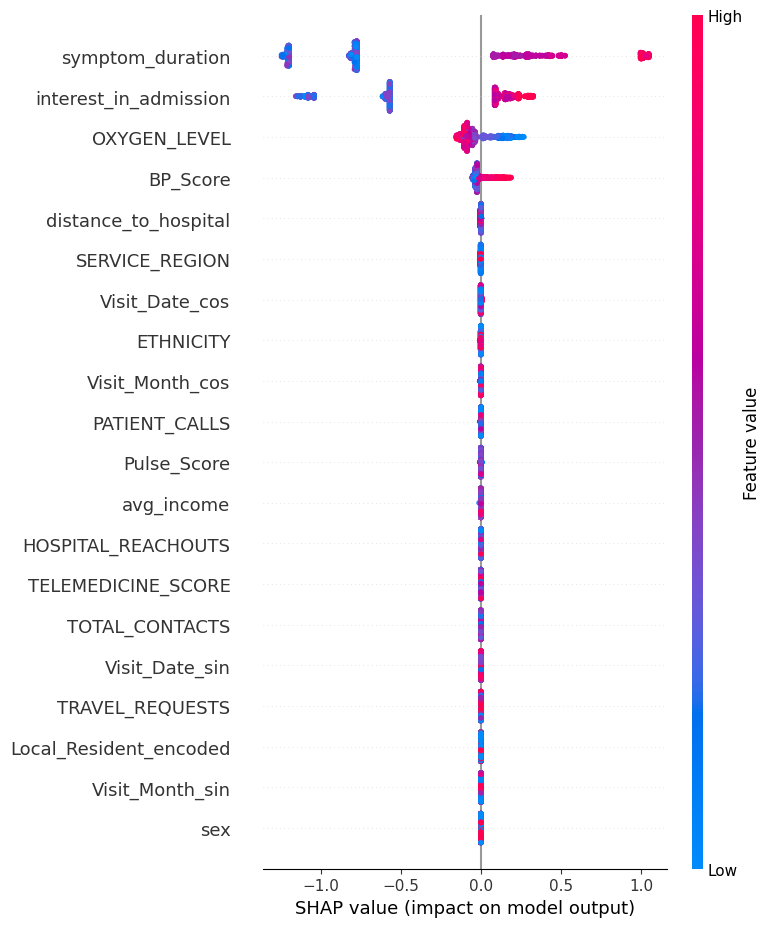

In [123]:
# generate SHAP values for the xgboost model
explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_test_enc)
# summary plot
shap.summary_plot(shap_values, X_test_enc)